# Introduction

We train a simple densely connected autoencoder on MNIST. We then visualize:

1. Test reconstructions
2. Decoding random latent codes
3. Autoencoding random images
4. Learning a latent-code invariant image transformer.

# Imports / load data

In [16]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_test = ds_test.batch(100)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for i in ds_train.take(1):
  print(i[0])

In [17]:
for i in ds_test.take(1):
  print(i[0].shape)

(100, 28, 28, 1)


# Create encoder and decoder

In [ ]:
act='relu'

enc = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation=act),
  tf.keras.layers.Dense(128,activation=act),
  tf.keras.layers.Dense(16, activation=act)
])

dec = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, input_shape=(16, )),
  tf.keras.layers.Dense(128,activation=act),
  tf.keras.layers.Dense(28 * 28 * 1,activation=act),
  tf.keras.layers.Reshape((28,28,1,))  
])


opt = tf.optimizers.Adam(2e-4)




for epoch in range(5):
  for batch in ds_train:
    with tf.GradientTape() as tape:
      recons = dec(enc(batch[0]))
      loss = tf.linalg.norm(recons-batch[0],axis=[1,2])
      loss = tf.reduce_mean(loss)
      print(loss)
      (g_enc, g_dec) = tape.gradient(loss,(enc.trainable_variables, dec.trainable_variables))
    opt.apply_gradients(zip(g_enc, enc.trainable_variables))
    opt.apply_gradients(zip(g_dec, dec.trainable_variables))

# Check reconstructions

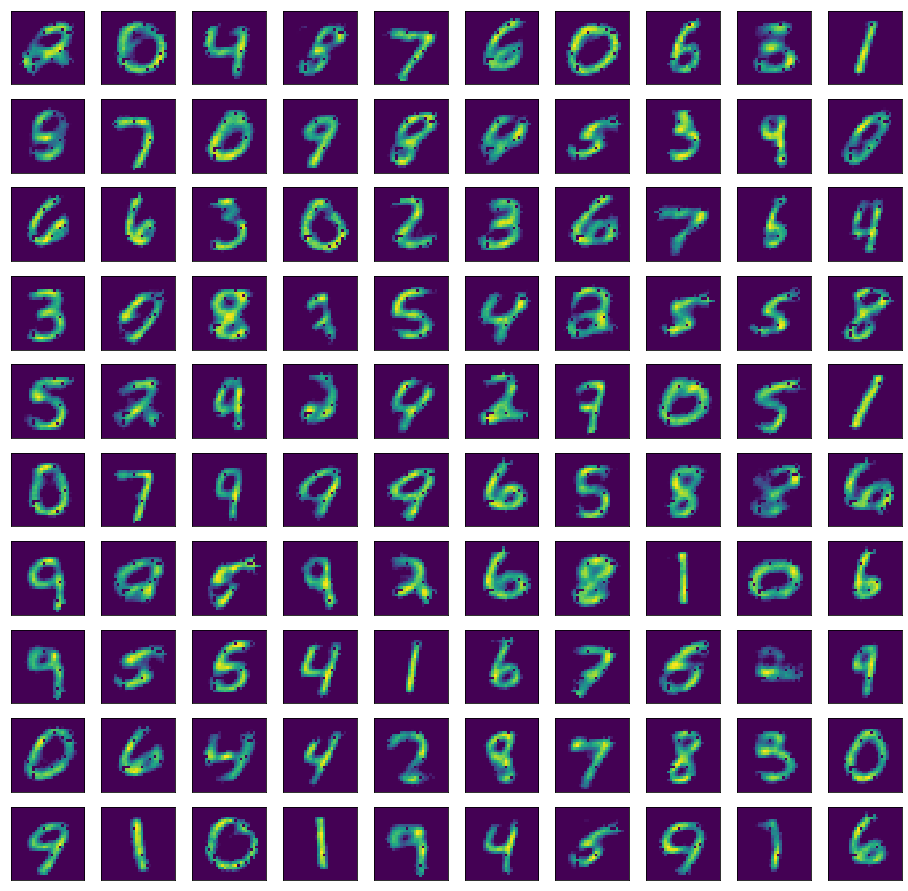

In [26]:
import matplotlib.pyplot as plt


for test_images in ds_test.take(1):
  test_images = test_images[0]
  recons = dec(enc(test_images))
  images = recons.numpy().reshape((100,28,28))

  fig, axes = plt.subplots(10, 10, figsize=(16,16))
  for row in range(len(axes)):
    for col in range(len(axes[row])):
      axes[row][col].get_xaxis().set_visible(False)
      axes[row][col].get_yaxis().set_visible(False)
      axes[row][col].matshow(images[row*10+col])
      # axes[row][col].matshow(latents[row*10+col])

# Encode decode random pixel arrays

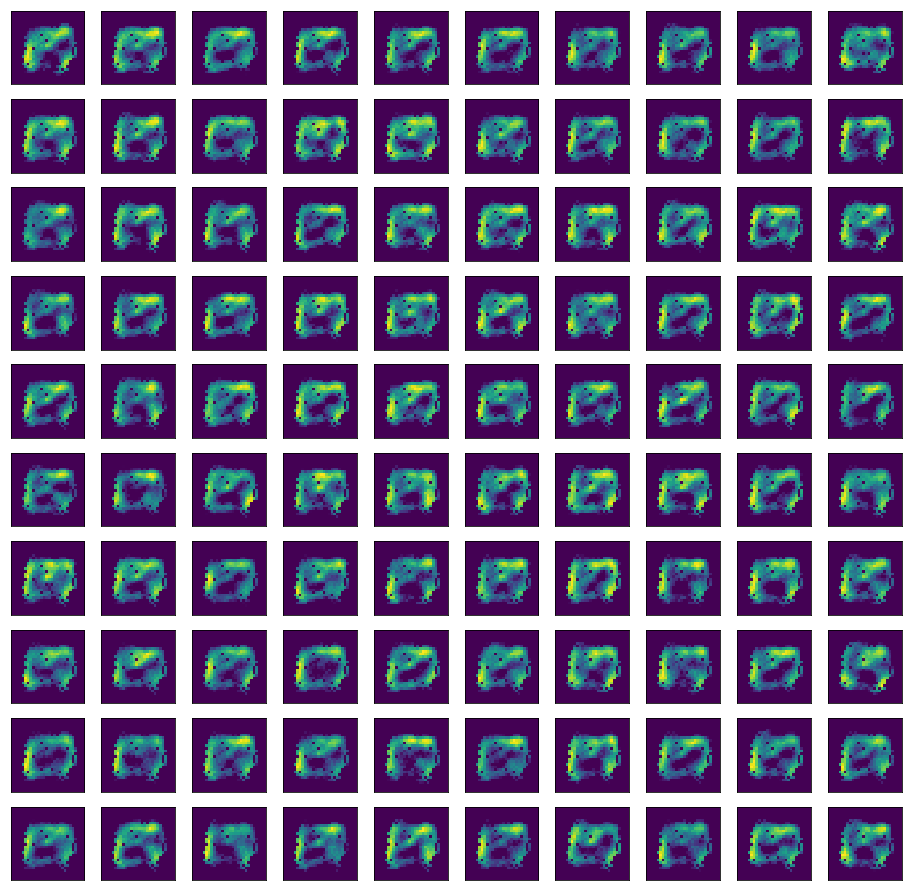

In [ ]:
randoms = tf.random.uniform(shape=(100,28,28,1),minval=0.0,maxval=1.)
# randoms = tf.random.normal(shape=(100,28,28,1),mean=0.5,stddev=0.3)
# latents = enc(randoms).numpy().reshape((100,16,1))
images = dec(enc(randoms))
images = images.numpy().reshape((100,28,28))

fig, axes = plt.subplots(10, 10, figsize=(16,16))
for row in range(len(axes)):
  for col in range(len(axes[row])):
    axes[row][col].get_xaxis().set_visible(False)
    axes[row][col].get_yaxis().set_visible(False)
    axes[row][col].matshow(images[row*10+col])
    # axes[row][col].matshow(latents[row*10+col])

# Generate from random latent codes

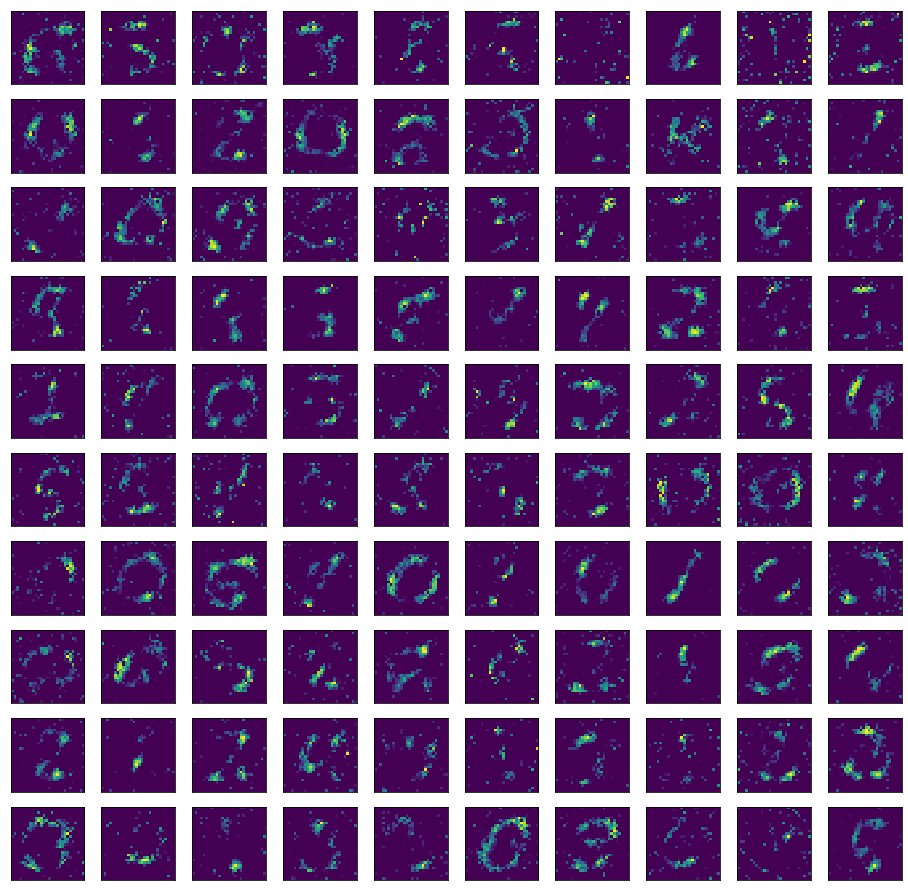

In [ ]:
randoms = tf.random.uniform(shape=(100,16),minval=-1.,maxval=1.)
# randoms = tf.random.normal(shape=(100,16),mean=0.0,stddev=1.0)
images = dec(randoms)
images = images.numpy().reshape((100,28,28))

fig, axes = plt.subplots(10, 10, figsize=(16,16))
for row in range(len(axes)):
  for col in range(len(axes[row])):
    axes[row][col].get_xaxis().set_visible(False)
    axes[row][col].get_yaxis().set_visible(False)
    axes[row][col].matshow(images[row*10+col])

## dec(enc(dec(randoms)))

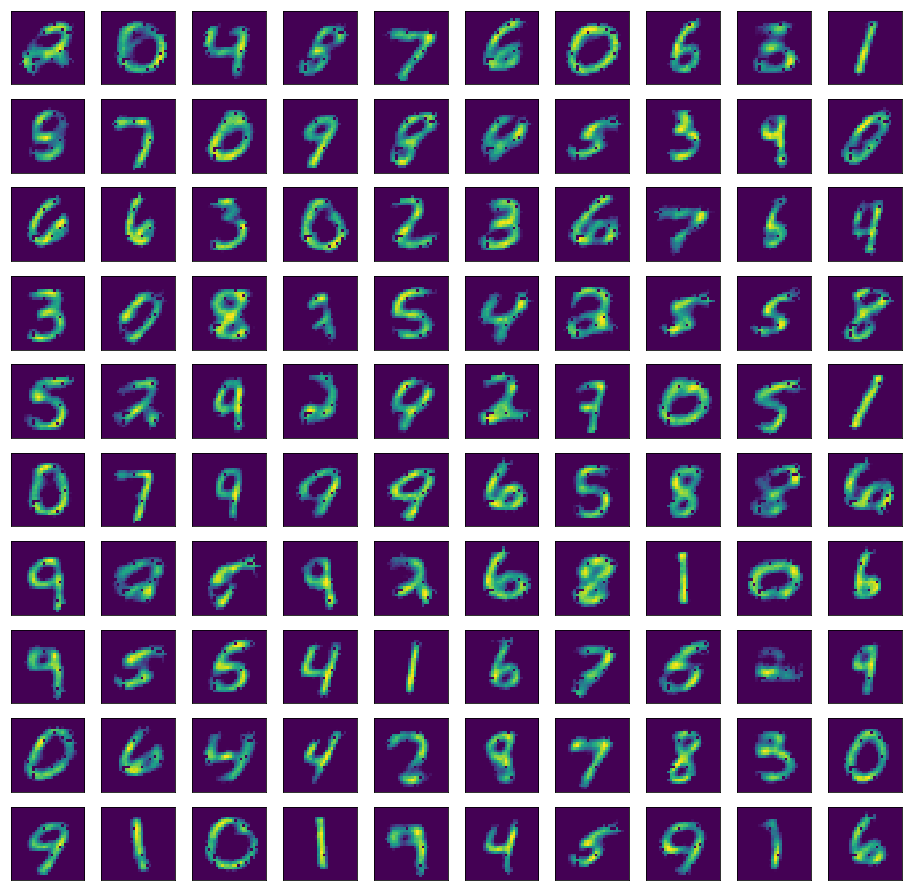

In [27]:
# randoms = tf.random.uniform(shape=(100,16),minval=-1.,maxval=1.)
# randoms = tf.random.normal(shape=(100,16),mean=0.0,stddev=1.0)
# images = dec(randoms)
# images = images.numpy().reshape((100,28,28))
images = dec(enc(images))
images = images.numpy().reshape((100,28,28))

fig, axes = plt.subplots(10, 10, figsize=(16,16))
for row in range(len(axes)):
  for col in range(len(axes[row])):
    axes[row][col].get_xaxis().set_visible(False)
    axes[row][col].get_yaxis().set_visible(False)
    axes[row][col].matshow(images[row*10+col])

# Learning classifier-invariant transforms

1. Train classifier or encoder
2. Transform $T$ maps pixels to pixels
3. Error is difference in output of encoder after transform compared to before transform, minimize this difference; also no identity function

## For single image

In [ ]:
transform = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(28 * 28 * 1, activation='relu'),
  tf.keras.layers.Reshape((28,28,1,))  
])


#real pixels
IMAGE_IDX = 10
real_image = batch[0].numpy()[IMAGE_IDX].reshape((1,28,28,1))
print(real_image.shape)

# real latent code
lc = tf.constant(enc(batch[0]).numpy()[IMAGE_IDX].reshape((1,16)))

# error
transformed_image = transform(real_image)
error = tf.linalg.norm(lc - enc(transformed_image))


opt = tf.optimizers.Adam(1e-4)

while True:
  print("Error: ",error.numpy())
  with tf.GradientTape() as tape:
    transformed_image = transform(real_image)
    error = tf.linalg.norm(lc - enc(transformed_image))
    if error<=0.005:
      break
    g = tape.gradient(error, transform.trainable_variables)    
  opt.apply_gradients(zip(g, transform.trainable_variables))
  

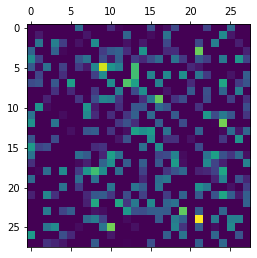

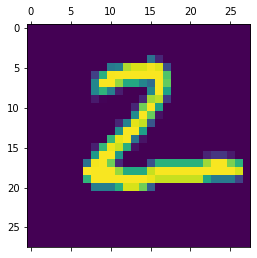

In [ ]:
plt.matshow(transform(real_image).numpy().reshape((28,28)))
plt.matshow(batch[0].numpy()[IMAGE_IDX].reshape((28,28)))


In [ ]:
print(enc(real_image), enc(transform(real_image)))
print(tf.linalg.norm(enc(real_image) - enc(transform(real_image))))

tf.Tensor(
[[0.         3.9073372  0.91563743 3.887989   5.3923497  0.81523347
  0.         3.331448   2.8805249  0.42126587 2.5990107  0.
  3.8380504  2.4765856  0.         2.8629062 ]], shape=(1, 16), dtype=float32) tf.Tensor(
[[0.         3.9076524  0.91734344 3.8872037  5.3923655  0.813887
  0.         3.331731   2.8814106  0.41997847 2.5987992  0.
  3.8384213  2.4755325  0.         2.8648067 ]], shape=(1, 16), dtype=float32)
tf.Tensor(0.003586754, shape=(), dtype=float32)


## For batch of images

In [ ]:
transform = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='tanh'),
  tf.keras.layers.Dense(28 * 28 * 1, activation='tanh'),
  tf.keras.layers.Reshape((28,28,1,))  
])

opt = tf.optimizers.Adam(5e-5)

for epochs in range(8):
  for batch in ds_train:
    
    # real latent codes
    lcs = tf.constant(enc(batch))

    with tf.GradientTape() as tape:
      # error
      transformed_images = transform(batch)
      error = tf.reduce_mean(tf.linalg.norm(tf.subtract(lcs, enc(transformed_images)),axis=1))
      g = tape.gradient(error, transform.trainable_variables)    
      print(error.numpy())


    opt.apply_gradients(zip(g, transform.trainable_variables))

    

[[0.         1.7546477  4.215211   4.7472315  4.2462907  4.664786
  1.3240757  3.9344857  4.418726   0.         2.2492764  4.2879853
  1.2302228  0.         0.75089884 3.9126902 ]]
[[0.        1.8183777 4.1388144 4.6493354 4.167905  4.5729394 1.2356905
  3.8578548 4.3857527 0.        2.229347  4.182917  1.2317551 0.
  0.7911286 3.881677 ]]


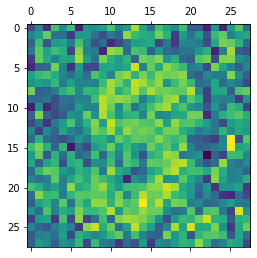

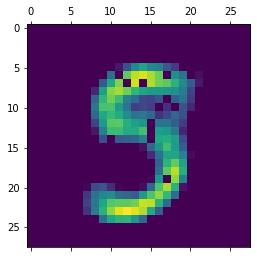

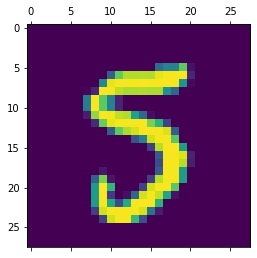

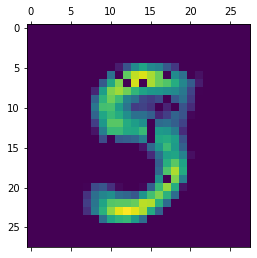

In [ ]:
import random
IMAGE_IDX=random.randint(0,32)
plt.matshow(transform(batch).numpy()[IMAGE_IDX].reshape((28,28)))
plt.matshow(dec(enc(transform(batch))).numpy()[IMAGE_IDX].reshape((28,28)))
plt.matshow(batch[0].numpy()[IMAGE_IDX].reshape((28,28)))
plt.matshow(dec(enc(batch[0])).numpy()[IMAGE_IDX].reshape((28,28)))


print(enc(transform(batch)).numpy()[IMAGE_IDX:IMAGE_IDX+1])
print(enc(batch).numpy()[IMAGE_IDX:IMAGE_IDX+1])

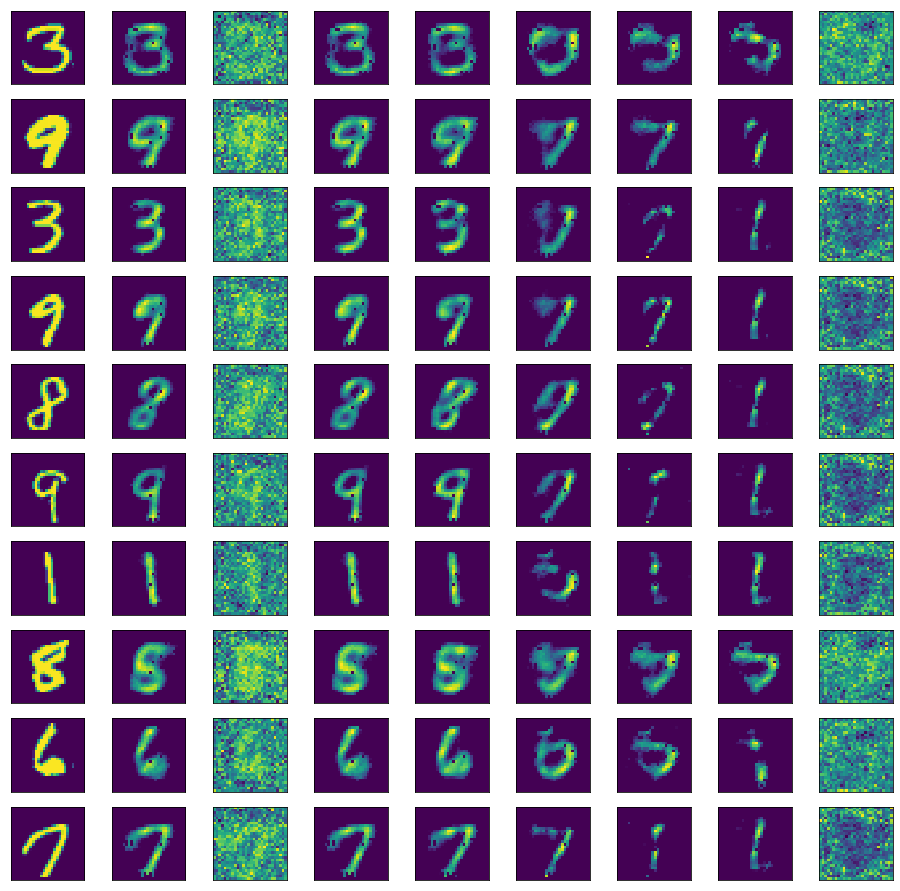

In [ ]:
data_iter = iter(ds_train)
batch = data_iter.next()
original = batch[0]
autoencoded = dec(enc(batch))
transformed = transform(batch)
transformed2 = transform(transformed)
transformed7 = transform(transform(transform(transform(transform(transformed2)))))
transformed14 = transform(transform(transform(transform(transform(transformed7)))))
transformed21 = transform(transform(transform(transform(transform(transformed14)))))
ae_trans = dec(enc(transformed))
ae_trans2 = dec(enc(transformed2))
ae_trans7 = dec(enc(transformed7))
ae_trans14 = dec(enc(transformed14))
ae_trans21 = dec(enc(transformed21))


fig, axes = plt.subplots(10, 9, figsize=(16,16))
for row in range(len(axes)):
  for col,data in zip(range(len(axes[row])), [original,autoencoded,transformed,ae_trans,ae_trans2,ae_trans7,ae_trans14,ae_trans21,transformed21]):
    axes[row][col].get_xaxis().set_visible(False)
    axes[row][col].get_yaxis().set_visible(False)
    axes[row][col].matshow(data.numpy()[row].reshape((28,28)))